In [29]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

image_data = nib.load('../images/FLAIR.nii.gz').get_fdata()

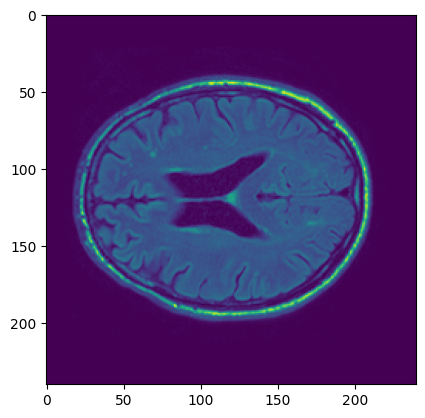

In [30]:
plt.imshow(image_data[:,:,25])

### Estadarizar

In [31]:
def zscore_image(image_data):
    mean_value = image_data[image_data > 10].mean()
    standard_deviation_value = image_data[image_data > 10].std()


    image_data_rescaled = (image_data - mean_value) / (standard_deviation_value)

    return image_data_rescaled

def rescale_image(image_data):
    min_value = image_data.min()
    max_value = image_data.max()

    image_data_rescaled = (image_data - min_value) / (max_value - min_value)

    return image_data_rescaled

def white_stripe(image):
    # 1. Calcular el histograma de la imagen
    histogram = np.histogram(image, bins=256, range=(0, 255))[0]

    # 2. Dividir el histograma en tres secciones
    section_size = len(histogram) // 3
    section3 = histogram[2 * section_size:]

    peak3 = np.argmax(section3)
    ws = peak3 + 2 * section_size

    image_data_rescaled = (image / ws)

    return image_data_rescaled


### Remocion de ruido

In [32]:
def medianFilterBorders (image):
  # Median Filter with borders
	threshold = 2500
	filtered_image = np.zeros_like(image)

	for x in range(1, image.shape[0] - 2):
		for y in range(1, image.shape[1] - 2):
			for z in range(1, image.shape[2] - 2):
        # Compute the derivatives in x, y, and z directions
				dx = image[x + 1, y, z] - image[x - 1, y, z]
				dy = image[x, y + 1, z] - image[x, y - 1, z]
				dz = image[x, y, z + 1] - image[x, y, z - 1]

        # Compute the magnitude of the gradient
				magnitude = np.sqrt(dx * dx + dy * dy + dz * dz)

                    # Separate pixels based on the current threshold
				below_threshold = magnitude[magnitude < threshold]
				above_threshold = magnitude[magnitude >= threshold]
				threshold = (np.mean(below_threshold) + np.mean(above_threshold)) / 2

				if magnitude < threshold:
					neighbours = []
					for dx in range(-1, 2):
						for dy in range(-1, 2):
							for dz in range(-1, 2):
								neighbours.append(image[x + dx, y + dy, z + dz])
					median = np.median(neighbours)
					filtered_image[x, y, z] = median
				else:
					filtered_image[x, y, z] = image[x, y, z]
	return filtered_image

def meanFilterBorders (image):
  # Median Filter with borders
	threshold = 2500
	filtered_image = np.zeros_like(image)

	for x in range(1, image.shape[0] - 2):
		for y in range(1, image.shape[1] - 2):
			for z in range(1, image.shape[2] - 2):
        # Compute the derivatives in x, y, and z directions
				dx = image[x + 1, y, z] - image[x - 1, y, z]
				dy = image[x, y + 1, z] - image[x, y - 1, z]
				dz = image[x, y, z + 1] - image[x, y, z - 1]

        # Compute the magnitude of the gradient
				magnitude = np.sqrt(dx * dx + dy * dy + dz * dz)

                    # Separate pixels based on the current threshold
				below_threshold = magnitude[magnitude < threshold]
				above_threshold = magnitude[magnitude >= threshold]
				threshold = (np.mean(below_threshold) + np.mean(above_threshold)) / 2

				if magnitude < threshold:
					for x in range (0, image_data.shape[0]-2):
						for y in range(0, image_data.shape[1]-2):
							for z in range(0, image_data.shape[2]-2):
								# voxel_int = image_data[x,y,z]

								avg = 0

								for dx in range(-1,1) :
									for dy in range(-1,1) :
										for dz in range(-1,1) :
											avg = avg + image_data[x+dx, y+dy, z+dz]

								filtered_image[x,y,z] = avg / 3 ** 3
				else:
					filtered_image[x, y, z] = image[x, y, z]
	return filtered_image

def median_filter(image_data):
    filtered_image = np.zeros_like(image_data)

    for x in range(1, image_data.shape[0]-1):
        for y in range(1, image_data.shape[1]-1):
            for z in range(1, image_data.shape[2]-1):
                # Extraer la vecindad 3x3x3
                neighborhood = image_data[x-1:x+2, y-1:y+2, z-1:z+2]

                new_neighborhood = np.sort(neighborhood)
                
                # Calcular la mediana de la vecindad
                median_value = np.median(new_neighborhood)
                
                # Asignar el valor mediano al píxel filtrado
                filtered_image[x, y, z] = median_value

    return filtered_image

def mean_filter_image(image_data):
    filtered_image = np.zeros_like(image_data)
    for x in range (0, image_data.shape[0]-2):
        for y in range(0, image_data.shape[1]-2):
            for z in range(0, image_data.shape[2]-2):
                # voxel_int = image_data[x,y,z]

                avg = 0

                for dx in range(-1,1) :
                    for dy in range(-1,1) :
                        for dz in range(-1,1) :
                            avg = avg + image_data[x+dx, y+dy, z+dz]

                filtered_image[x,y,z] = avg / 3 ** 3
    return  filtered_image

### Segmentar

In [33]:
def kmeans_segmentation(image, k, tol, max_iter):
    # Inicializamos los centroides con valores entre el mínimo y el máximo valor de la imagen
    centroids = np.linspace(np.min(image), np.max(image), k)

    for i in range(max_iter):
        # Calculamos la distancia entre los valores de la imagen y los centroides
        distances = np.abs(image - centroids[..., None, None, None])

        # Asignamos cada pixel a su centroide más cercano
        segmentation = np.argmin(distances, axis=0)

        # Calculamos los nuevos centroides como la media de los valores asignados a cada cluster
        new_centroids = np.array([np.mean(image[segmentation == j]) for j in range(k)])

        # Comprobamos si la diferencia entre los nuevos y los antiguos centroides es menor que la tolerancia
        if np.all(np.abs(new_centroids - centroids) < tol):
            break

        # Asignamos los nuevos centroides
        centroids = new_centroids

    return segmentation

In [34]:
# Estadarizada = white_stripe(image_data)
Remocion_de_ruido = medianFilterBorders(image_data)
Segmentar = kmeans_segmentation(Remocion_de_ruido, 6, 1, 10)

In [35]:
Segmentar_No_preprocess = kmeans_segmentation(image_data, 6, 1, 10)

Text(0.5, 1.0, 'Preprocesada')

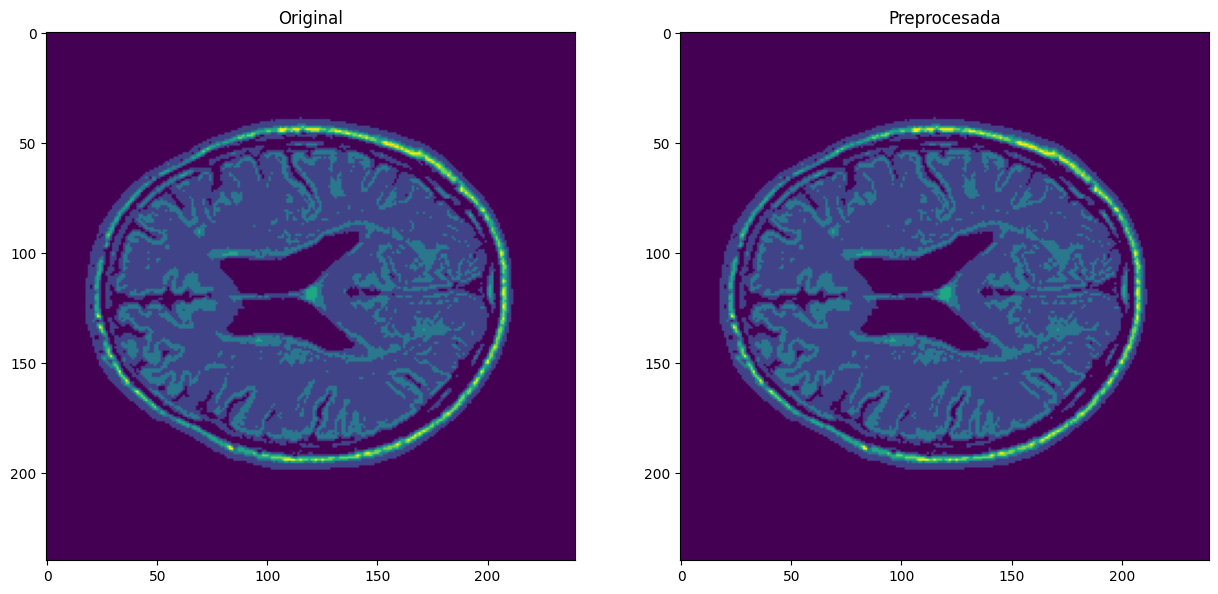

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(Segmentar_No_preprocess[:, :, 25])
ax1.set_title('Original')
ax2.imshow(Segmentar[:, :, 25])
ax2.set_title('Preprocesada')

In [37]:
# Estadarizada2 = white_stripe(image_data)
Remocion_de_ruido2 = meanFilterBorders(image_data)
Segmentar2 = kmeans_segmentation(Remocion_de_ruido2, 6, 1, 10)

Text(0.5, 1.0, 'Preprocesada')

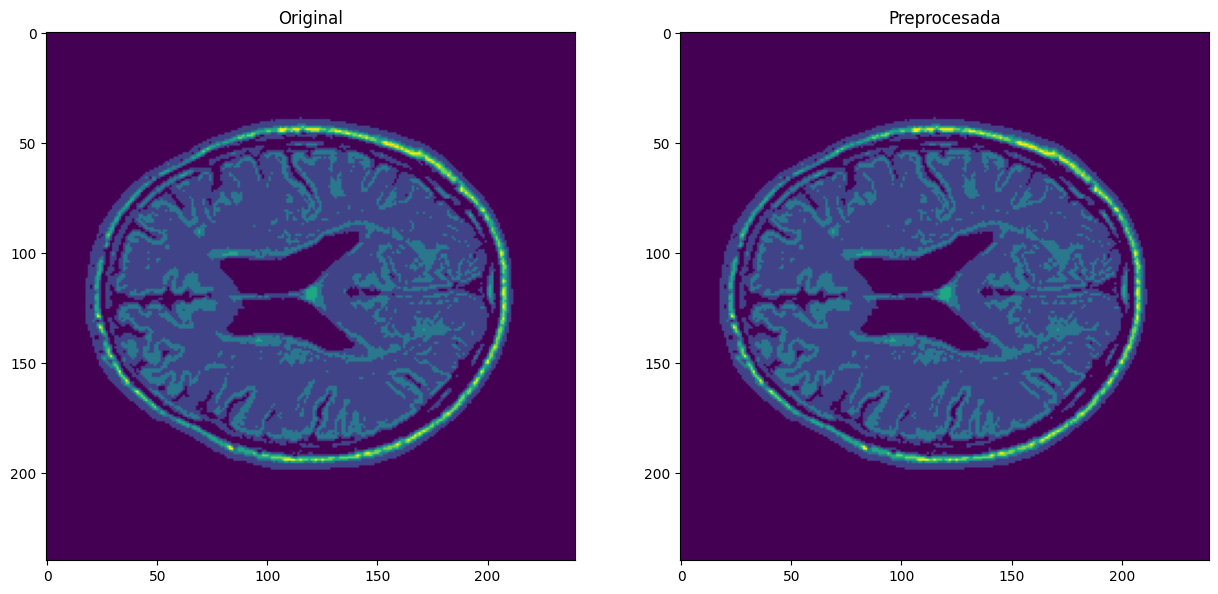

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(Segmentar_No_preprocess[:, :, 25])
ax1.set_title('Original')
ax2.imshow(Segmentar2[:, :, 25])
ax2.set_title('Preprocesada')

In [39]:
# Estadarizada2 = white_stripe(image_data)
Remocion_de_ruido3 = median_filter(image_data)
Segmentar3 = kmeans_segmentation(Remocion_de_ruido3, 6, 1, 10)

Text(0.5, 1.0, 'Preprocesada')

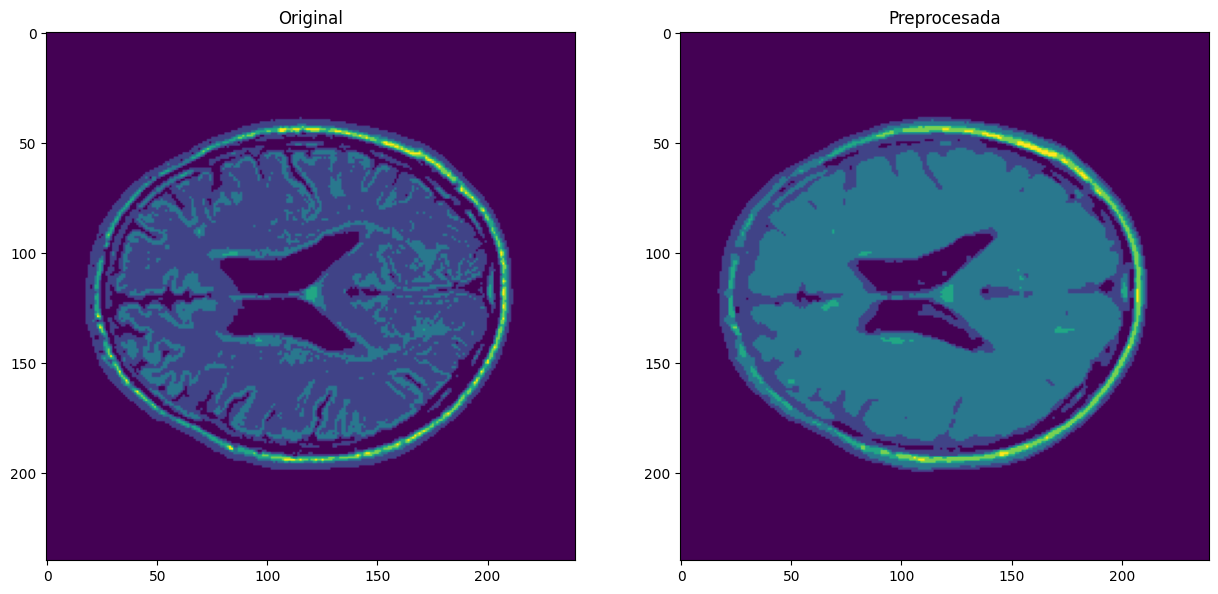

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(Segmentar_No_preprocess[:, :, 25])
ax1.set_title('Original')
ax2.imshow(Segmentar3[:, :, 25])
ax2.set_title('Preprocesada')

In [41]:
# Estadarizada2 = white_stripe(image_data)
Remocion_de_ruido4 = mean_filter_image(image_data)
Segmentar4 = kmeans_segmentation(Remocion_de_ruido4, 6, 1, 10)

Text(0.5, 1.0, 'Preprocesada')

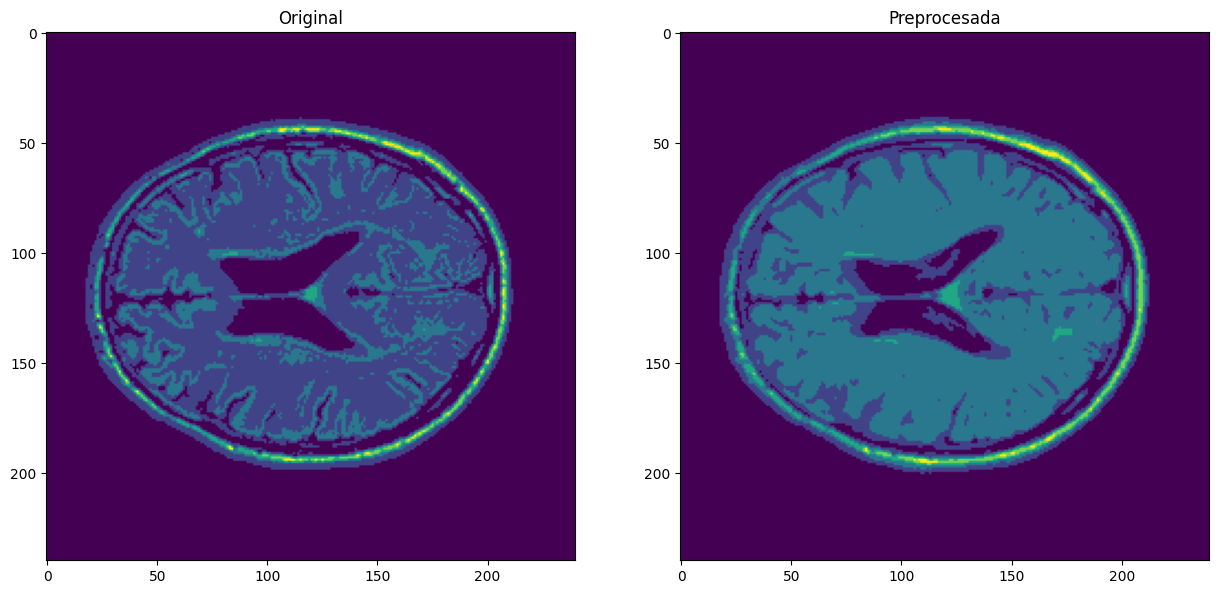

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.imshow(Segmentar[:, :, 25])
ax1.set_title('Original')
ax2.imshow(Segmentar4[:, :, 25])
ax2.set_title('Preprocesada')

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 8))
ax1.imshow(Segmentar[:, :, 25])
ax1.set_title('medianFilterBorders')
ax2.imshow(Segmentar2[:, :, 25])
ax2.set_title('meanFilterBorders')
ax3.imshow(Segmentar3[:, :, 25])
ax3.set_title('median_filter')
ax4.imshow(Segmentar4[:, :, 25])
ax4.set_title('Preprocesada')